In [1]:
import numpy as np
import torch
from microgrid_RL_agents import Network
from microgrid_env import MicroGrid, naive_controller, cost_per_step, cost_per_step_hybrid
from microgrid_mpc import MicrogridMPC
from microgrid_fun import preprocess_state, state_norm, get_state_bounds, get_input_size, build_delta_vector, get_linear_reward_bounds, qp_feasible, print_mdl_variables
from config import mpc_param_dict, action_dict, action_dict_SL
from utils import get_optimality_gap, get_greedy_action
import time
import random
import matplotlib.pyplot as plt
import gc
import copy

data = np.load('data_entso/data_costs_loads_2021_2022.npy', allow_pickle=True)
data_2021 = data[0]; data_2022 = data[1]
cbuy_2021, csell_2021, cprod_2021, power_load_2021, power_res_2021 = data_2021
cbuy_2022, csell_2022, cprod_2022, power_load_2022, power_res_2022 = data_2022
cbuy, csell, cprod, power_load, power_res = data_2021

In [2]:
# Builds a MPC instance with model mistmatch

mpc_param_dict_mismatch = copy.deepcopy(mpc_param_dict)
#MLD equations
Ts = 1/2 # Ts = 30m
# nd = 0.99
# nc = 0.9
nd = 0.95
nc = 0.86

mpc_param_dict_mismatch['Amld'] = np.array([
    [1]
])
mpc_param_dict_mismatch['B1'] = np.array([
    [Ts/nd,0,0,0,0]
])
mpc_param_dict_mismatch['B3']= np.array([
    [Ts*(nc-1/nd),0]
])

33.62706787109374
0.10075377231353089


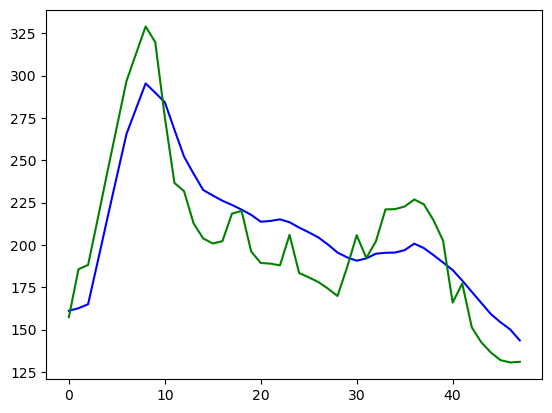

In [157]:
N = 48
n_threads=1
mpc = MicrogridMPC(N, mpc_param_dict, n_threads)
mpc_mismatch = MicrogridMPC(N, mpc_param_dict_mismatch, n_threads)
Env = MicroGrid(N, mpc)

def inject_noise_sine(N, amplitude, n_periods, length=0, partial=False):
    
    if partial == True:
        y = np.zeros((N,))
        init_idx = np.random.randint(0,N-length)
        end_idx = init_idx+length
        x_sin = np.linspace(-np.pi, np.pi, length)
        y[init_idx:end_idx] = amplitude*np.sin(x_sin*n_periods + 2*np.pi*np.random.rand())
        
    elif partial == False:
        x_sin = np.linspace(-np.pi, np.pi, N)      
        y_sin = amplitude*np.sin(x_sin*n_periods + 2*np.pi*np.random.rand())
        y = y_sin
    
    return y

def inject_noise_constant(N, max_amplitude, length):
    
    y = np.zeros((N,))
    init_idx = np.random.randint(0,N-length)
    end_idx = init_idx+length
    y[init_idx:end_idx] = 2*max_amplitude*np.random.rand()-max_amplitude
    
    return y

def inject_noise_gaussian(signal, amplitude, N, n_reps):
        
    noise_res = amplitude*np.repeat(np.random.randn(np.ceil(N/n_reps).astype(np.int32)),n_reps)[:N]*signal
    
    return noise_res

def bound_noise(original_signal, noisy_signal, max_rel_distance=0.08, min_abs_error=15):
        
    noisy_signal = noisy_signal.copy()
        
    max_envelope = original_signal + max_rel_distance*np.abs(original_signal) + min_abs_error
    min_envelope = original_signal - max_rel_distance*np.abs(original_signal) - min_abs_error
    
    noisy_signal[noisy_signal>max_envelope] = max_envelope[noisy_signal>max_envelope]
    noisy_signal[noisy_signal<min_envelope] = min_envelope[noisy_signal<min_envelope]
    
    noisy_signal[noisy_signal<0] = 0
    
    return noisy_signal, max_envelope, min_envelope

def normalized_iae(x, y):
    #normalized integral absolute error
    
    numerator = np.sum(np.abs(x - y))
    denominator = np.sum(np.abs(x))
    return numerator / denominator

def inject_noise_all(original_signal):


    N = original_signal.shape[0]
    length_1 = np.ceil(N/5).astype(np.int32)
    
    noisy_signal = original_signal + inject_noise_gaussian(original_signal, amplitude=0.05, N=N, n_reps=length_1)
    for i in range(4):
        noisy_signal = noisy_signal + inject_noise_constant(N=N, max_amplitude=40, length=length_1)
    for i in range(4):
        noisy_signal = noisy_signal + inject_noise_sine(N, amplitude=5, n_periods=3, length=length_1, partial=True)
    noisy_signal = noisy_signal + inject_noise_sine(N, amplitude=25, n_periods=3, length=10, partial=False)
    noisy_signal = noisy_signal + inject_noise_sine(N, amplitude=10, n_periods=8, length=10, partial=False)
    noisy_signal = noisy_signal + inject_noise_sine(N, amplitude=5, n_periods=13, length=10, partial=False)
    noisy_signal = noisy_signal + inject_noise_sine(N, amplitude=5, n_periods=26, length=10, partial=False)
    # noisy_signal[0] = original_signal[0]
    bounded_noisy_signal, max_envelope, min_envelope = bound_noise(original_signal, noisy_signal, max_rel_distance=0.08, min_abs_error=10)
    
    return bounded_noisy_signal

Env.set_randState(power_res, power_load, cbuy, csell, cprod)
# original_signal = Env.power_res_tmp
# original_signal = Env.power_load_tmp
# original_signal = power_load[Env.idx_cntr:Env.idx_cntr+N*3]
original_signal = power_res[Env.idx_cntr:Env.idx_cntr+N]
bounded_noisy_signal = inject_noise_all(original_signal)

plt.plot(original_signal, 'b')
# plt.plot(max_envelope, '-.b')
# plt.plot(min_envelope, '-.b')
# plt.plot(noisy_signal, 'r')
plt.plot(bounded_noisy_signal, 'g')
# plt.ylim(0, 700)
# plt.ylim(0, 1000)
print(np.max(np.abs(bounded_noisy_signal-original_signal)))
print(normalized_iae(original_signal, bounded_noisy_signal))

In [158]:
Env.set_randState(power_res, power_load, cbuy, csell, cprod)
# original_signal = Env.power_res_tmp
# original_signal = Env.power_load_tmp
original_signal_load = power_load[Env.idx_cntr:Env.idx_cntr+N]
original_signal_res = power_res[Env.idx_cntr:Env.idx_cntr+N]
bounded_noisy_signal_load = inject_noise_all(original_signal_load)
bounded_noisy_signal_res = inject_noise_all(original_signal_res)

print(Env.idx_cntr)

4218


In [159]:
print(Env.state)

[[66.68438473]]


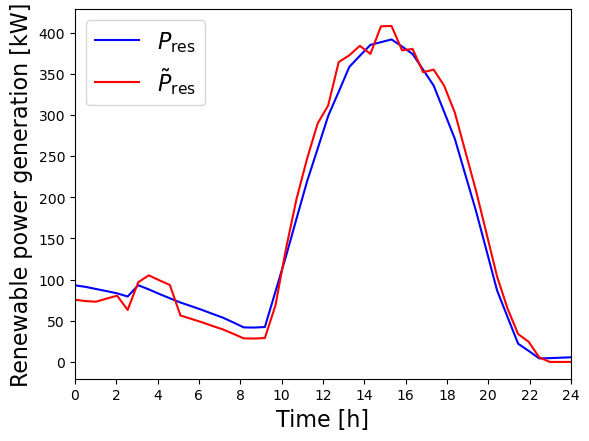

In [160]:
t = np.linspace(0, 24, original_signal.shape[0])
ticks = np.arange(0,26, 2)

fontsize=16
plt.plot(t, original_signal_res, 'b', label='$P_{\\mathrm{res}}$')
plt.plot(t, bounded_noisy_signal_res, 'r', label='$\\tilde{P}_\\mathrm{res}$')
plt.xlim((0,24))
plt.xticks(ticks)
plt.xlabel('Time [h]', fontsize=fontsize)
plt.ylabel('Renewable power generation [kW]', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.savefig('plots/res_power_mismatch.pdf', bbox_inches='tight')


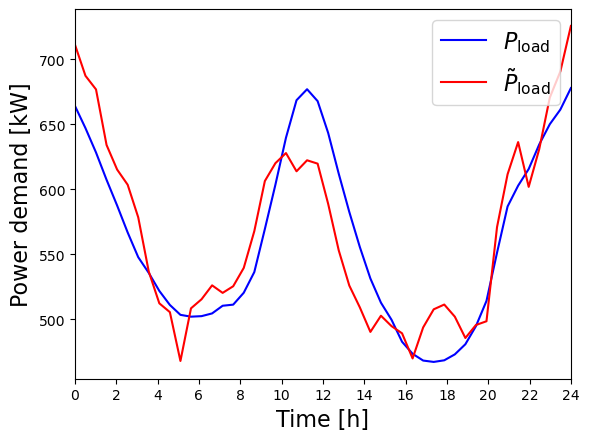

In [161]:
t = np.linspace(0, 24, original_signal.shape[0])
ticks = np.arange(0,26, 2)

fontsize=16
plt.plot(t, original_signal_load, 'b', label='$P_{\\mathrm{load}}$')
plt.plot(t, bounded_noisy_signal_load, 'r', label='$\\tilde{P}_\\mathrm{load}$')
plt.xlim((0,24))
plt.xticks(ticks)
plt.xlabel('Time [h]', fontsize=fontsize)
plt.ylabel('Power demand [kW]', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.savefig('plots/load_power_mismatch.pdf', bbox_inches='tight')

In [162]:
# Computes the average IAE for the load and renewables

list_iae = []
n_iter=10000
for i in range(n_iter):
    Env.set_randState(power_res, power_load, cbuy, csell, cprod)
    original_signal = power_res[Env.idx_cntr:Env.idx_cntr+N*3]
    bounded_noisy_signal = inject_noise_all(original_signal)
    list_iae.append(normalized_iae(original_signal, bounded_noisy_signal))
    
np.mean(list_iae)

np.float64(0.10459306915411366)

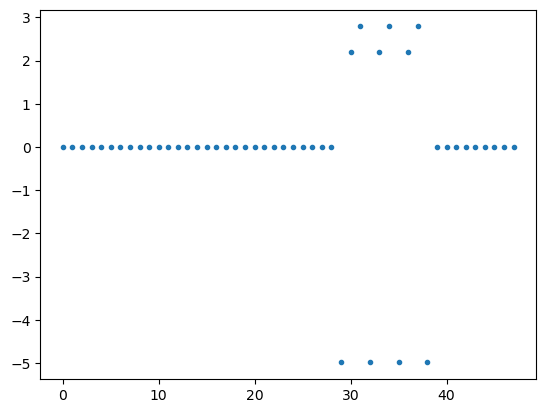

In [163]:
# Plots the different noises individually

tmp = inject_noise_sine(N, amplitude=5, n_periods=6, length=10, partial=True)
# tmp = inject_noise_sine(N, amplitude=5, n_periods=26, length=10, partial=False)
# tmp = inject_noise_constant(N=N, max_amplitude=1000, length=10)
# tmp = inject_noise_gaussian(original_signal, amplitude=0.1, N=N, n_reps=6)
plt.plot(tmp, ".")

---------------------------------------

In [164]:
match N:
    case 4:
        experiment = 2
        idx = 40 # 49 / 19 / 144 (exp1)  --------  10 / 40 (exp2)
        net_opt = 'last' 
    case 12:
        experiment = 2
        idx = 48 # 121 / 49 / 41 (exp1)  -------- 0 / 48 (exp2)
        net_opt = 'last'
    case 24:
        experiment = 2
        idx = 0 # 9 / 144 / 147 (exp1)  -------- 0 / 146 (exp2)
        net_opt = 'last'
    case 48:
        experiment = 2
        idx = 58 # 0 / 47 (exp1)  -------- 42 / 58 (exp2)
        net_opt='last'

dict_network = np.load('new_best_weights/N_%.2d/info_exp%.2d_%.3d.npy' %(N,experiment,idx), allow_pickle=True).item()

In [165]:
# Loads network for RL approach

seed = 4
n_threads=1

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.set_num_threads(n_threads)

mpc = MicrogridMPC(N, mpc_param_dict, n_threads)
Env = MicroGrid(N, mpc)

input_size = dict_network['input_size']
hidden_size = dict_network['hidden_size']
num_layers = dict_network['num_layers']
lr = dict_network['lr']
n_actions = dict_network['n_actions']
state_opt = dict_network['state_opt']
state_min = dict_network['state_min']
state_max = dict_network['state_max']
opt_rew = dict_network['opt_rew']

network = Network(input_size, hidden_size, num_layers, lr, n_actions)
network.load_state_dict(torch.load('new_best_weights/N_%.2d/weight_exp%.2d_%.3d_%s.npy' %(N,experiment,idx,net_opt), weights_only=True))
network.eval()
h0 = torch.zeros(num_layers, 1, hidden_size)
c0 = torch.zeros(num_layers, 1, hidden_size)
network

Network(
  (lstm): LSTM(193, 256, batch_first=True)
  (dense): Linear(in_features=256, out_features=16, bias=True)
  (loss): MSELoss()
)

In [18]:
# Open-loop test of the RL training (check consistency with training results)

N_iter=1000
timeout=60
cost_lower_bound, cost_upper_bound = get_linear_reward_bounds(N)
avg_cost_lstm, avg_cost_optimal, optimality_gap, infeas_rate, N_iter = get_optimality_gap(network, Env, N_iter, cbuy, csell, cprod, power_load,
                       power_res, state_min, state_max, state_opt, cost_upper_bound, cost_lower_bound, opt_rew, timeout)
print('N = %.2d' %N)
print('Optimality gap (open-loop) is %.2f' %(optimality_gap*100))
print('Infeasibility (1/1000) (open-loop) is %.2f' %infeas_rate)
print('Number of samples is %d' %N_iter)

N = 12
Optimality gap (open-loop) is 0.38
Infeasibility (1/1000) (open-loop) is 1.00
Number of samples is 1000


In [166]:
# Load supervised network (SL)

state_opt_SL = 1
input_size_SL= 6 # for opt1
hidden_size_SL= 128
num_layers_SL = 1
lr_SL = 1e-4
n_actions_SL = 32
batch_size_SL = 1

h0_SL = torch.zeros(num_layers_SL, batch_size_SL, hidden_size_SL)
c0_SL = torch.zeros(num_layers_SL, batch_size_SL, hidden_size_SL)

state_min_SL = np.array([25, np.min(cbuy_2022), np.min(cprod_2022), np.min(csell_2022), np.min(power_load_2022), np.min(power_res_2022)])
state_max_SL = np.array([250, np.max(cbuy_2022), np.max(cprod_2022), np.max(csell_2022), np.max(power_load_2022), np.max(power_res_2022)])

network_SL = Network(input_size_SL, hidden_size_SL, num_layers_SL, lr_SL, n_actions_SL, batch_first=True)
network_SL.load_state_dict(torch.load('best_weights//microgrid_lstm_supervised_%d_N%d_opt1' %(hidden_size_SL,N), weights_only=True))
network_SL.eval()
#

Network(
  (lstm): LSTM(6, 128, batch_first=True)
  (dense): Linear(in_features=128, out_features=32, bias=True)
  (loss): MSELoss()
)

In [20]:
# Computes the open-loop optimality gap
gc.disable()

niter=3000
list_cost_RL = []
list_cost_optimal_RL = []
list_cost_SL = []
list_cost_optimal_SL = []
cntr_infeas_RL = 0
cntr_infeas_SL = 0

list_time_SL = []
list_time_RL = []
list_time_hybrid=[]
for i in range(niter):
    Env.set_randState(power_res, power_load, cbuy, csell, cprod)
    
    start_time=time.perf_counter()
    mpc.build_opt_matrices_hybrid(Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
    mdl_milp = mpc.solve_hybrid_gurobi(Env.state)
    list_time_hybrid.append(time.perf_counter()-start_time)

    start_time=time.perf_counter()
    state = preprocess_state(state_opt, Env.state, N, network.input_size, state_min, state_max, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp, Env.power_load_tmp, Env.power_res_tmp)
    action_idx = get_greedy_action(network, state, h0=h0, c0=c0)
    delta = build_delta_vector(action_idx, N, action_dict)
    mpc.build_opt_matrices(Env.state.reshape(-1,),delta.reshape(-1,), Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
    mdl_RL = mpc.solve_gurobi_lp()
    list_time_RL.append(time.perf_counter()-start_time)
    
    start_time=time.perf_counter()
    x0_tmp = np.repeat(Env.state, N)
    state_SL = np.dstack((x0_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp, Env.power_res_tmp, Env.power_load_tmp)).squeeze()
    state_SL = state_norm(state_SL, state_min_SL, state_max_SL).astype(np.float32)
    state_SL = torch.tensor(state_SL, dtype=torch.float32).unsqueeze(0)
    output_net = network_SL(state_SL, h0_SL, c0_SL)
    action_idx_SL = torch.max(output_net, dim=2)[1].squeeze().numpy()
    # action_idx_SL = get_greedy_action(network_SL, state_SL, h0=h0_SL, c0=c0_SL)
    delta_SL = build_delta_vector(action_idx_SL, N, action_dict_SL)
    # state_SL = preprocess_state(state_opt_SL, Env.state, N, network_SL.input_size, state_min_SL, state_max_SL, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp, Env.power_load_tmp, Env.power_res_tmp)
    # 
    mpc.build_opt_matrices(Env.state.reshape(-1,),delta_SL.reshape(-1,), Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
    mdl_SL = mpc.solve_gurobi_lp()
    list_time_SL.append(time.perf_counter()-start_time)

    if qp_feasible(mdl_milp)==True and qp_feasible(mdl_RL)==True:
        list_cost_optimal_RL.append(mdl_milp.ObjVal)
        list_cost_RL.append(mdl_RL.ObjVal)
    if qp_feasible(mdl_milp)==True and qp_feasible(mdl_RL)==False:
        cntr_infeas_RL +=1
        
    if qp_feasible(mdl_milp)==True and qp_feasible(mdl_SL)==True:
        list_cost_optimal_SL.append(mdl_milp.ObjVal)
        list_cost_SL.append(mdl_SL.ObjVal)
    if qp_feasible(mdl_milp)==True and qp_feasible(mdl_SL)==False:
        cntr_infeas_SL +=1
        
infeas_rate_RL = cntr_infeas_RL/niter*1000
mean_cost_optimal_RL = np.mean(list_cost_optimal_RL)
mean_cost_RL = np.mean(list_cost_RL)
optimality_gap_RL = (mean_cost_RL-mean_cost_optimal_RL)/mean_cost_optimal_RL*100

infeas_rate_SL = cntr_infeas_SL/niter*1000
mean_cost_optimal_SL = np.mean(list_cost_optimal_SL)
mean_cost_SL = np.mean(list_cost_SL)
optimality_gap_SL = (mean_cost_SL-mean_cost_optimal_SL)/mean_cost_optimal_SL*100

# with open('final_test.txt', 'a') as f:
#     f.write('\nOpen-loop test')
#     f.write('\nN=%.2d, experiment %d, idx %d' %(N,experiment,idx))
#     f.write('\nNumber of samples: %d' %niter)
#     f.write('\nOptimality gap (open-loop) for RL/SL is %.2f/%.2f' %(optimality_gap_RL, optimality_gap_SL))
#     f.write('\nInfeasibility rate (1/1000) (open-loop) for RL/SL is %.2f/%.2f \n' %(infeas_rate_RL, infeas_rate_SL))
    
print('Open-loop test')
print('N=%.2d' %N)
print('Optimality gap (open-loop) for RL/SL is %.2f/%.2f' %(optimality_gap_RL, optimality_gap_SL))
print('Infeasibility rate (1/1000) (open-loop) for RL/SL is %.2f/%.2f' %(infeas_rate_RL, infeas_rate_SL))
print('Number of samples: %d' %niter)

n_cut = 200
n_samples = niter - n_cut

# with open('final_test.txt', 'a') as f:
#     f.write('\nComputation time test')
#     f.write('\nN=%.2d, experiment %d, idx %d' %(N,experiment,idx))
#     f.write('\n(mean, max, std)')
#     f.write('\nn_samples = %d' %n_samples)
#     f.write('\nRL: %.4f/%.4f/%.4f' %(np.mean(list_time_RL[n_cut:]), np.max(list_time_RL[n_cut:]), np.std(list_time_RL[n_cut:])))
#     f.write('\nSL: %.4f/%.4f/%.4f' %(np.mean(list_time_SL[n_cut:]), np.max(list_time_SL[n_cut:]), np.std(list_time_SL[n_cut:])))
#     f.write('\nHybrid: %.4f/%.4f/%.4f\n' %(np.mean(list_time_hybrid[n_cut:]), np.max(list_time_hybrid[n_cut:]), np.std(list_time_hybrid[n_cut:])))

print('\nComputation time test')
print('N=%.2d, experiment %d, idx %d' %(N,experiment,idx))
print('(mean, max, std)')
print('n_samples = %d' %n_samples)
print('RL: %.4f/%.4f/%.4f' %(np.mean(list_time_RL[n_cut:]), np.max(list_time_RL[n_cut:]), np.std(list_time_RL[n_cut:])))
print('SL: %.4f/%.4f/%.4f' %(np.mean(list_time_SL[n_cut:]), np.max(list_time_SL[n_cut:]), np.std(list_time_SL[n_cut:])))
print('Hybrid: %.4f/%.4f/%.4f\n' %(np.mean(list_time_hybrid[n_cut:]), np.max(list_time_hybrid[n_cut:]), np.std(list_time_hybrid[n_cut:])))

gc.enable()

Open-loop test
N=12
Optimality gap (open-loop) for RL/SL is 0.36/0.12
Infeasibility rate (1/1000) (open-loop) for RL/SL is 2.33/12.33
Number of samples: 3000

Computation time test
N=12, experiment 2, idx 48
(mean, max, std)
n_samples = 2800
RL: 0.0041/0.0328/0.0012
SL: 0.0039/0.0209/0.0012
Hybrid: 0.0176/0.0672/0.0046



In [21]:
# Computes the open-loop optimality gap (including heuristic)
gc.disable()

niter=3000
list_cost_RL = []
list_cost_SL = []
list_cost_hybrid = []
list_cost_heuristic = []
cntr_infeas_RL = 0
cntr_infeas_SL = 0

list_time_SL = []
list_time_RL = []
list_time_hybrid=[]
list_time_heuristic=[]

#warmup
for _ in range(100):
    Env.set_randState(power_res, power_load, cbuy, csell, cprod)
    
    mpc.build_opt_matrices_hybrid(Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
    mdl_milp = mpc.solve_hybrid_gurobi(Env.state)
    
    state = preprocess_state(state_opt, Env.state, N, network.input_size, state_min, state_max, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp, Env.power_load_tmp, Env.power_res_tmp)
    action_idx = get_greedy_action(network, state, h0=h0, c0=c0)
    delta = build_delta_vector(action_idx, N, action_dict)
    mpc.build_opt_matrices(Env.state.reshape(-1,),delta.reshape(-1,), Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
    mdl_RL = mpc.solve_gurobi_lp()
    
    x0_tmp = np.repeat(Env.state, N)
    state_SL = np.dstack((x0_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp, Env.power_res_tmp, Env.power_load_tmp)).squeeze()
    state_SL = state_norm(state_SL, state_min_SL, state_max_SL).astype(np.float32)
    state_SL = torch.tensor(state_SL, dtype=torch.float32).unsqueeze(0)
    output_net = network_SL(state_SL, h0_SL, c0_SL)
    action_idx_SL = torch.max(output_net, dim=2)[1].squeeze().numpy()
    delta_SL = build_delta_vector(action_idx_SL, N, action_dict_SL)
    mpc.build_opt_matrices(Env.state.reshape(-1,),delta_SL.reshape(-1,), Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
    mdl_SL = mpc.solve_gurobi_lp()


for i in range(niter):
    Env.set_randState(power_res, power_load, cbuy, csell, cprod)
    
    start_time=time.perf_counter()
    mpc.build_opt_matrices_hybrid(Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
    mdl_milp = mpc.solve_hybrid_gurobi(Env.state)
    list_time_hybrid.append(time.perf_counter()-start_time)
    
    Env.power_res_tmp = inject_noise_all(Env.power_res_tmp)
    Env.power_load_tmp = inject_noise_all(Env.power_load_tmp)

    start_time=time.perf_counter()
    state = preprocess_state(state_opt, Env.state, N, network.input_size, state_min, state_max, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp, Env.power_load_tmp, Env.power_res_tmp)
    action_idx = get_greedy_action(network, state, h0=h0, c0=c0)
    delta = build_delta_vector(action_idx, N, action_dict)
    mpc.build_opt_matrices(Env.state.reshape(-1,),delta.reshape(-1,), Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
    mdl_RL = mpc.solve_gurobi_lp()
    if qp_feasible(mdl_RL)==False:
        cntr_infeas_RL += 1
        list_action = naive_controller(Env.power_res_tmp, Env.power_load_tmp)
        delta = Env.build_delta_vector(list_action)
        mpc.build_opt_matrices(Env.state.reshape(-1,),delta.reshape(-1,), Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
        mdl_RL = mpc.solve_gurobi_lp()
    list_time_RL.append(time.perf_counter()-start_time)
    
    start_time=time.perf_counter()
    x0_tmp = np.repeat(Env.state, N)
    state_SL = np.dstack((x0_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp, Env.power_res_tmp, Env.power_load_tmp)).squeeze()
    state_SL = state_norm(state_SL, state_min_SL, state_max_SL).astype(np.float32)
    state_SL = torch.tensor(state_SL, dtype=torch.float32).unsqueeze(0)
    output_net = network_SL(state_SL, h0_SL, c0_SL)
    action_idx_SL = torch.max(output_net, dim=2)[1].squeeze().numpy()
    # action_idx_SL = get_greedy_action(network_SL, state_SL, h0=h0_SL, c0=c0_SL)
    delta_SL = build_delta_vector(action_idx_SL, N, action_dict_SL)
    # state_SL = preprocess_state(state_opt_SL, Env.state, N, network_SL.input_size, state_min_SL, state_max_SL, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp, Env.power_load_tmp, Env.power_res_tmp)
    # 
    mpc.build_opt_matrices(Env.state.reshape(-1,),delta_SL.reshape(-1,), Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
    mdl_SL = mpc.solve_gurobi_lp()
    if qp_feasible(mdl_SL)==False:
        cntr_infeas_SL += 1
        list_action = naive_controller(Env.power_res_tmp, Env.power_load_tmp)
        delta = Env.build_delta_vector(list_action)
        mpc.build_opt_matrices(Env.state.reshape(-1,),delta.reshape(-1,), Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
        mdl_SL = mpc.solve_gurobi_lp()
    list_time_SL.append(time.perf_counter()-start_time)
    
    start_time = time.perf_counter()
    list_action = naive_controller(Env.power_res_tmp, Env.power_load_tmp)
    delta = Env.build_delta_vector(list_action)
    mpc.build_opt_matrices(Env.state.reshape(-1,),delta.reshape(-1,), Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
    mdl_heuristic = mpc.solve_gurobi_lp()
    list_time_heuristic.append(time.perf_counter()-start_time)
    
    list_cost_RL.append(mdl_RL.ObjVal)
    list_cost_SL.append(mdl_SL.ObjVal)
    list_cost_hybrid.append(mdl_milp.ObjVal)
    list_cost_heuristic.append(mdl_heuristic.ObjVal)

    # if qp_feasible(mdl_milp)==True and qp_feasible(mdl_RL)==True:
    #     list_cost_hybrid.append(mdl_milp.ObjVal)
    #     list_cost_RL.append(mdl_RL.ObjVal)
    # if qp_feasible(mdl_milp)==True and qp_feasible(mdl_RL)==False:
    #     cntr_infeas_RL +=1
        
    # if qp_feasible(mdl_milp)==True and qp_feasible(mdl_SL)==True:
    #     list_cost_hybrid.append(mdl_milp.ObjVal)
    #     list_cost_SL.append(mdl_SL.ObjVal)
    # if qp_feasible(mdl_milp)==True and qp_feasible(mdl_SL)==False:
    #     cntr_infeas_SL +=1
        
infeas_rate_RL = cntr_infeas_RL/niter*1000
infeas_rate_SL = cntr_infeas_SL/niter*1000

mean_cost_hybrid = np.mean(list_cost_hybrid)
mean_cost_RL = np.mean(list_cost_RL)
optimality_gap_RL = (mean_cost_RL-mean_cost_hybrid)/mean_cost_hybrid*100
mean_cost_SL = np.mean(list_cost_SL)
optimality_gap_SL = (mean_cost_SL-mean_cost_hybrid)/mean_cost_hybrid*100
mean_cost_heuristic = np.mean(list_cost_heuristic)
optimality_gap_heuristic = (mean_cost_heuristic-mean_cost_hybrid)/mean_cost_hybrid*100

# with open('final_test.txt', 'a') as f:
#     f.write('\nOpen-loop test')
#     f.write('\nN=%.2d, experiment %d, idx %d' %(N,experiment,idx))
#     f.write('\nNumber of samples: %d' %niter)
#     f.write('\nOptimality gap (open-loop) for RL/SL is %.2f/%.2f' %(optimality_gap_RL, optimality_gap_SL))
#     f.write('\nInfeasibility rate (1/1000) (open-loop) for RL/SL is %.2f/%.2f \n' %(infeas_rate_RL, infeas_rate_SL))
    
print('Open-loop test')
print('N=%.2d' %N)
print('Optimality gap (open-loop) for RL/SL/Heuristic is %.2f/%.2f/%.2f' %(optimality_gap_RL, optimality_gap_SL, optimality_gap_heuristic))
print('Infeasibility rate (1/1000) (open-loop) for RL/SL is %.2f/%.2f' %(infeas_rate_RL, infeas_rate_SL))
print('Number of samples: %d' %niter)

n_cut = 200
n_samples = niter - n_cut

# with open('final_test.txt', 'a') as f:
#     f.write('\nComputation time test')
#     f.write('\nN=%.2d, experiment %d, idx %d' %(N,experiment,idx))
#     f.write('\n(mean, max, std)')
#     f.write('\nn_samples = %d' %n_samples)
#     f.write('\nRL: %.4f/%.4f/%.4f' %(np.mean(list_time_RL[n_cut:]), np.max(list_time_RL[n_cut:]), np.std(list_time_RL[n_cut:])))
#     f.write('\nSL: %.4f/%.4f/%.4f' %(np.mean(list_time_SL[n_cut:]), np.max(list_time_SL[n_cut:]), np.std(list_time_SL[n_cut:])))
#     f.write('\nHybrid: %.4f/%.4f/%.4f\n' %(np.mean(list_time_hybrid[n_cut:]), np.max(list_time_hybrid[n_cut:]), np.std(list_time_hybrid[n_cut:])))

print('\nComputation time test')
print('N=%.2d, experiment %d, idx %d' %(N,experiment,idx))
print('(mean, max, std)')
print('n_samples = %d' %n_samples)
print('RL: %.4f/%.4f/%.4f' %(np.mean(list_time_RL[n_cut:]), np.max(list_time_RL[n_cut:]), np.std(list_time_RL[n_cut:])))
print('SL: %.4f/%.4f/%.4f' %(np.mean(list_time_SL[n_cut:]), np.max(list_time_SL[n_cut:]), np.std(list_time_SL[n_cut:])))
print('Hybrid: %.4f/%.4f/%.4f\n' %(np.mean(list_time_hybrid[n_cut:]), np.max(list_time_hybrid[n_cut:]), np.std(list_time_hybrid[n_cut:])))
print('Heuristic: %.4f/%.4f/%.4f' %(np.mean(list_time_heuristic[n_cut:]), np.max(list_time_heuristic[n_cut:]), np.std(list_time_heuristic[n_cut:])))

gc.enable()

Open-loop test
N=12
Optimality gap (open-loop) for RL/SL/Heuristic is 0.41/0.21/1.44
Infeasibility rate (1/1000) (open-loop) for RL/SL is 4.00/36.67
Number of samples: 3000

Computation time test
N=12, experiment 2, idx 48
(mean, max, std)
n_samples = 2800
RL: 0.0053/0.0172/0.0034
SL: 0.0053/0.0186/0.0035
Hybrid: 0.0227/0.1932/0.0162

Heuristic: 0.0041/0.0123/0.0027


In [33]:
# Compares the computation time between RL and hybrid
gc.disable()

N_iter=2200
list_time_SL = []
list_time_RL = []
list_time_hybrid=[]
for i in range(N_iter):

    Env.set_randState(power_res, power_load, cbuy, csell, cprod)
      
    start_time=time.perf_counter()
    x0_tmp = np.repeat(Env.state, N)
    state_SL = np.dstack((x0_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp, Env.power_res_tmp, Env.power_load_tmp)).squeeze()
    state_SL = state_norm(state_SL, state_min_SL, state_max_SL).astype(np.float32)
    state_SL = torch.tensor(state_SL, dtype=torch.float32).unsqueeze(0)
    output_net = network_SL(state_SL, h0_SL, c0_SL)
    action_idx_SL = torch.max(output_net, dim=2)[1].squeeze().numpy()
    delta_SL = build_delta_vector(action_idx_SL, N, action_dict_SL)
    mpc.build_opt_matrices(Env.state.reshape(-1,),delta_SL.reshape(-1,), Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
    mdl_SL = mpc.solve_gurobi_lp()
    list_time_SL.append(time.perf_counter()-start_time)
    
    start_time=time.perf_counter()    
    state = preprocess_state(state_opt, Env.state, N, input_size, state_min, state_max, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp, Env.power_load_tmp, Env.power_res_tmp).astype(np.float32)
    action = get_greedy_action(network,state,h0,c0)
    delta = build_delta_vector(action, N, action_dict)
    mpc.build_opt_matrices(Env.state.reshape(-1,),delta.reshape(-1,), Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
    mdl = mpc.solve_gurobi_lp()    
    list_time_RL.append(time.perf_counter()-start_time)
    
    start_time=time.perf_counter()
    mpc.build_opt_matrices_hybrid(Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
    mpc.solve_hybrid_gurobi(Env.state)
    list_time_hybrid.append(time.perf_counter()-start_time)

n_cut = 200
n_samples = N_iter - n_cut

# with open('final_test.txt', 'a') as f:
#     f.write('\nComputation time test')
#     f.write('\nN=%.2d, experiment %d, idx %d' %(N,experiment,idx))
#     f.write('\n(mean, max, std)')
#     f.write('\nn_samples = %d' %n_samples)
#     f.write('\nRL: %.4f/%.4f/%.4f' %(np.mean(list_time_RL[n_cut:]), np.max(list_time_RL[n_cut:]), np.std(list_time_RL[n_cut:])))
#     f.write('\nSL: %.4f/%.4f/%.4f' %(np.mean(list_time_SL[n_cut:]), np.max(list_time_SL[n_cut:]), np.std(list_time_SL[n_cut:])))
#     f.write('\nHybrid: %.4f/%.4f/%.4f\n' %(np.mean(list_time_hybrid[n_cut:]), np.max(list_time_hybrid[n_cut:]), np.std(list_time_hybrid[n_cut:])))

print('Computation time test')
print('N=%.2d, experiment %d, idx %d' %(N,experiment,idx))
print('(mean, max, std)')
print('n_samples = %d' %n_samples)
print('RL: %.4f/%.4f/%.4f' %(np.mean(list_time_RL[n_cut:]), np.max(list_time_RL[n_cut:]), np.std(list_time_RL[n_cut:])))
print('SL: %.4f/%.4f/%.4f' %(np.mean(list_time_SL[n_cut:]), np.max(list_time_SL[n_cut:]), np.std(list_time_SL[n_cut:])))
print('Hybrid: %.4f/%.4f/%.4f\n' %(np.mean(list_time_hybrid[n_cut:]), np.max(list_time_hybrid[n_cut:]), np.std(list_time_hybrid[n_cut:])))

# print(np.mean(list_time_RL[n_cut:]), np.mean(list_time_hybrid[n_cut:]), np.max(list_time_RL[n_cut:]), np.max(list_time_hybrid[n_cut:]))

gc.enable()

Computation time test
N=24, experiment 2, idx 0
(mean, max, std)
n_samples = 2000
RL: 0.0044/0.0087/0.0005
SL: 0.0045/0.0103/0.0004
Hybrid: 0.0241/0.0915/0.0047



In [ ]:
# gc.disable()
# niter = 5000
# list_time_RL_net = np.zeros((niter,))
# list_time_RL_opt = np.zeros((niter,))
# Env.set_randState(power_res, power_load, cbuy, csell, cprod)
# for i in range(niter):
#     start_time=time.perf_counter()    
#     state = preprocess_state(state_opt, Env.state, N, input_size, state_min, state_max, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp, Env.power_load_tmp, Env.power_res_tmp).astype(np.float32)
#     action = get_greedy_action(network,state,h0,c0)
#     delta = build_delta_vector(action, N, action_dict)
#     list_time_RL_net[i] = time.perf_counter()-start_time
#     start_time=time.perf_counter()
#     mpc.build_opt_matrices(Env.state.reshape(-1,),delta.reshape(-1,), Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
#     mdl = mpc.solve_gurobi_lp()    
#     list_time_RL_opt[i] = time.perf_counter()-start_time

# print(list_time_RL_opt.mean(), list_time_RL_opt.max())
# gc.enable()

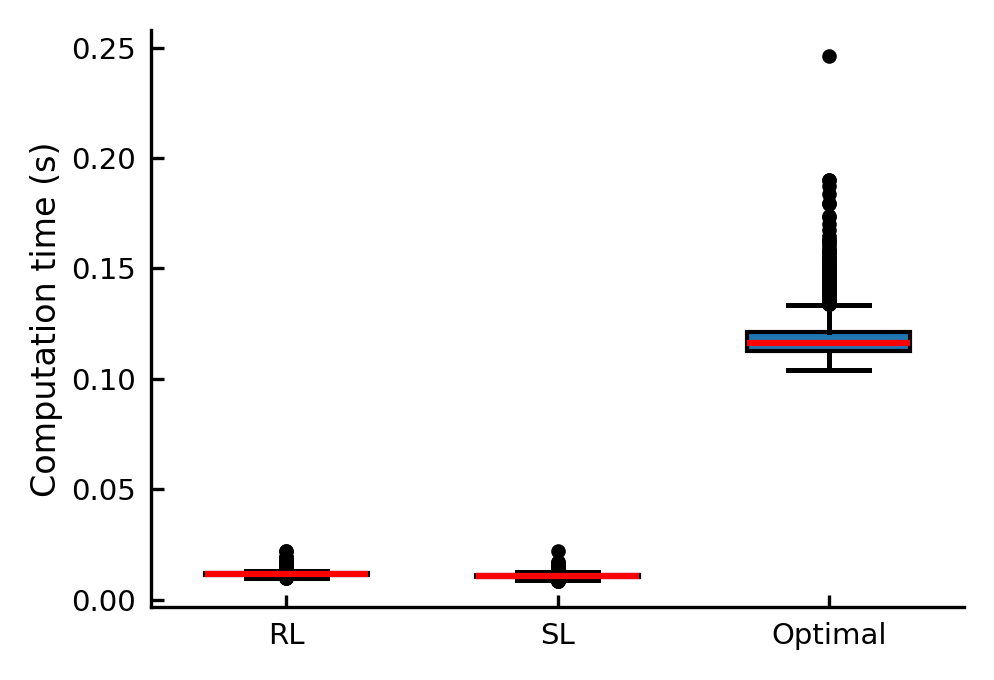

In [ ]:
# Generate sample data
# np.random.seed(42)
# data = [np.random.normal(loc=mu, scale=0.5, size=100) for mu in range(1, 6)]

# Create figure with increased DPI for publication quality
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300)  # IEEE column size

# Create the boxplot using Matplotlib
ax.boxplot((list_time_RL[n_cut:], list_time_SL[n_cut:], list_time_hybrid[n_cut:]), tick_labels=['RL', 'SL', 'Optimal'], widths=0.6, patch_artist=True, 
           medianprops=dict(color='red', linewidth=1.5),
           whiskerprops=dict(color='black', linewidth=1.2),
           capprops=dict(color='black', linewidth=1.2),
           flierprops=dict(marker='o', markersize=3, markerfacecolor='black', markeredgewidth=0.5))

# Set axis labels with LaTeX formatting
# ax.set_xlabel(r'Category', fontsize=8, labelpad=2)
ax.set_ylabel(r'Computation time (s)', fontsize=8, labelpad=2)

# Adjust tick label font size
ax.tick_params(axis='both', labelsize=7, direction='in', length=3, width=0.8)

# Remove unnecessary spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Save as vector format (PDF, EPS) for IEEE
plt.savefig("boxplot_latex_matplotlib.pdf", format="pdf", bbox_inches='tight')

plt.show()

In [15]:
# Closed-loop test of RL, SL and optimal policies with heuristic to guarantee feasibility

Env = MicroGrid(N,mpc)
Env_RL = MicroGrid(N,mpc)
Env_SL = MicroGrid(N,mpc)

N_iter = 50

cost_lower_bound, cost_upper_bound = get_linear_reward_bounds(N)
opt_rew = 'linear'

list_cost_RL=[]
list_cost_SL=[]
list_cost_optimal=[]
cntr=0
cntr_infeas_RL=0
cntr_infeas_SL=0
cntr_infeas_optimal=0

list_infeas_RL=[]
list_infeas_SL=[]

for i in range(N_iter):
    
    Env.set_randState(power_res, power_load, cbuy, csell, cprod)
    Env_RL.copyEnv(Env)
    Env_SL.copyEnv(Env)
    
    while (Env.terminated or Env.truncated)==False and (Env_RL.terminated or Env_RL.truncated)==False or (Env_SL.terminated or Env_SL.truncated)==False:
        
        state = preprocess_state(state_opt, Env_RL.state, N, input_size, state_min, state_max, Env_RL.cbuy_tmp, Env_RL.csell_tmp, Env_RL.cprod_tmp, Env_RL.power_load_tmp, Env_RL.power_res_tmp).astype(np.float32)
        action_idx = get_greedy_action(network,state,h0,c0)
        delta_RL = action_dict[str(action_idx[0])]
        # _, _, _, _, info_RL = Env_RL.step(action_idx, cbuy, csell, cprod, power_res, power_load,cost_upper_bound=cost_upper_bound, cost_lower_bound=cost_lower_bound, opt_rew=opt_rew)
        _, _, _, _, info_RL = Env_RL.step_heuristic(action_idx, cbuy, csell, cprod, power_res, power_load)
        
        x0_tmp = np.repeat(Env_SL.state, N)
        state_SL = np.dstack((x0_tmp, Env_SL.cbuy_tmp, Env_SL.csell_tmp, Env_SL.cprod_tmp, Env_SL.power_res_tmp, Env_SL.power_load_tmp)).squeeze()
        state_SL = state_norm(state_SL, state_min_SL, state_max_SL).astype(np.float32)
        state_SL = torch.tensor(state_SL, dtype=torch.float32).unsqueeze(0)
        output_net = network_SL(state_SL, h0_SL, c0_SL)
        action_idx_SL = torch.max(output_net, dim=2)[1].squeeze().numpy()
        delta_SL = action_dict_SL[str(action_idx_SL[0])]
        # state_SL = preprocess_state(state_opt_SL, Env_SL.state, N, input_size_SL, state_min_SL, state_max_SL, Env_SL.cbuy_tmp, Env_SL.csell_tmp, Env_SL.cprod_tmp, Env_SL.power_load_tmp, Env_SL.power_res_tmp).astype(np.float32)
        # action_idx_SL = get_greedy_action(network_SL,state_SL,h0_SL,c0_SL)
        # _, _, _, _, info_RL = Env_SL.step(action_idx_SL, cbuy, csell, cprod, power_res, power_load,cost_upper_bound=cost_upper_bound, cost_lower_bound=cost_lower_bound, opt_rew=opt_rew)
        _, _, _, _, info_SL = Env_SL.step_heuristic_SL(action_idx_SL, cbuy, csell, cprod, power_res, power_load)
        
        _, _, _, _, info_optimal = Env.step_optimal(cbuy, csell, cprod, power_res, power_load)
        
        if info_RL['feasible']==True and info_SL['feasible']==True and info_optimal['feasible']==True:
            list_cost_RL.append(Env_RL.stage_cost)
            list_cost_SL.append(Env_SL.stage_cost)        
            list_cost_optimal.append(Env.stage_cost)
        if info_RL['feasible']==False and info_optimal['feasible']==True:
            cntr_infeas_RL += 1
            list_infeas_RL.append([Env_RL.state, Env_RL.idx_cntr])
        if info_SL['feasible']==False and info_optimal['feasible']==True:
            cntr_infeas_SL += 1
            list_infeas_SL.append([Env_RL.state, Env_RL.idx_cntr])
        if info_optimal['feasible']==False: 
            cntr_infeas_optimal += 1
            
        cntr+=1

total_cost_RL = np.sum(list_cost_RL)
total_cost_SL = np.sum(list_cost_SL)
total_cost_optimal = np.sum(list_cost_optimal)
opt_gap_RL = (total_cost_RL-total_cost_optimal)/(total_cost_optimal)*100
opt_gap_SL = (total_cost_SL-total_cost_optimal)/(total_cost_optimal)*100

print('N=%.2d' %N)
print('RL/SL/Optimal mean costs are %.2f/%.2f/%.2f' %(np.mean(list_cost_RL), np.mean(list_cost_SL), np.mean(list_cost_optimal)))
print('RL/SL opt gaps are %.2f/%.2f' %(opt_gap_RL, opt_gap_SL))
print('Total number of samples: %d' %cntr)
print('Number of infeasible points (RL/SL/Optimal): %d/%d/%d' %(cntr_infeas_RL,cntr_infeas_SL,cntr_infeas_optimal))

N=48
RL/SL/Optimal mean costs are 241.87/242.43/241.49
RL/SL opt gaps are 0.16/0.39
Total number of samples: 1200
Number of infeasible points (RL/SL/Optimal): 0/0/0


In [167]:
def forward_step_env(Env, mdl, n_horizons, hybrid=False):
    # Updates the environment after the solution of an MPC step
    
    # Inputs:
    # Env: RL environment
    # mdl: gurobi model after solution
    
    if hybrid==False:
        Env.state=Env.mpc.A@Env.state + Env.mpc.B_u_a@np.array(mdl.x[:7])
    else:
        Env.state = np.clip(np.array(mdl.x[1]).reshape(-1,), 25+1e-4, 250)
    Env.cntr += 1
    Env.idx_cntr += 1            
    # Env.update_power_cost_data(power_res, power_load, cbuy, csell, cprod)
    
    # to guarantee feasibility of the LP if 25 <= x < 25+1e-4 (related to the tolerance of the solver)
    if Env.state >= 25 and Env.state <= 25+1e-4:
        Env.state = np.array([25+1e-4])
    
    # limites the duration of the episode
    if Env.cntr >= Env.pred_horizon*n_horizons:
        Env.truncated = True
    
    # limits the simulated system to the length of the dataset
    if Env.idx_cntr >= cbuy.shape[0]-Env.pred_horizon:
        Env.truncated = True

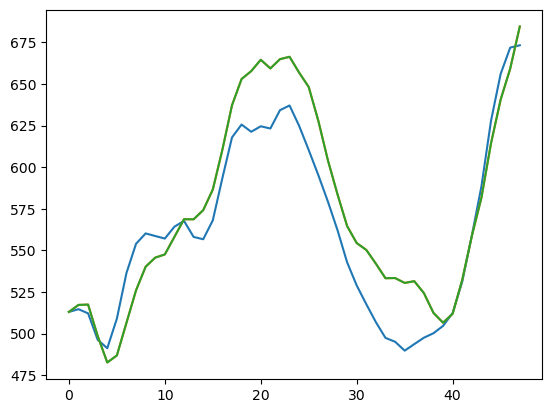

In [42]:
Env = MicroGrid(N,mpc)
Env_RL = MicroGrid(N,mpc)
Env_SL = MicroGrid(N,mpc)

Env.set_randState(power_res, power_load, cbuy, csell, cprod)
Env_RL.copyEnv(Env)
Env_SL.copyEnv(Env)

n_horizons=3

power_load_noisy = power_load.copy()
power_res_noisy = power_res.copy()

power_load_noisy[Env.idx_cntr:Env.idx_cntr+N*n_horizons] = inject_noise_all(power_load[Env.idx_cntr:Env.idx_cntr+N*n_horizons])
power_res_noisy[Env.idx_cntr:Env.idx_cntr+N*n_horizons] = inject_noise_all(power_res[Env.idx_cntr:Env.idx_cntr+N*n_horizons])

Env.update_power_cost_data(power_res, power_load, cbuy, csell, cprod)
Env_RL.update_power_cost_data(power_res_noisy, power_load_noisy, cbuy, csell, cprod)
Env_RL.power_load_tmp[0] = Env.power_load_tmp[0]
Env_RL.power_res_tmp[0] = Env.power_res_tmp[0]
Env_SL.update_power_cost_data(power_res_noisy, power_load_noisy, cbuy, csell, cprod)
Env_SL.power_load_tmp[0] = Env.power_load_tmp[0]
Env_SL.power_res_tmp[0] = Env.power_res_tmp[0]

plt.plot(Env.power_load_tmp)
plt.plot(Env_RL.power_load_tmp)
plt.plot(Env_SL.power_load_tmp)

# plt.plot(power_load_noisy[Env.idx_cntr:Env.idx_cntr+N*n_horizons])
# plt.plot(power_load[Env.idx_cntr:Env.idx_cntr+N*n_horizons])

In [43]:
# Closed-loop test of RL, SL and optimal policies with heuristic to guarantee feasibility

# Env = MicroGrid(N,mpc)
Env = MicroGrid(N,mpc_mismatch)
Env_RL = MicroGrid(N,mpc)
Env_SL = MicroGrid(N,mpc)

N_iter = 100

cost_lower_bound, cost_upper_bound = get_linear_reward_bounds(N)
opt_rew = 'linear'

list_cost_RL=[]
list_cost_SL=[]
list_cost_optimal=[]
cntr=0
cntr_infeas_RL=0
cntr_infeas_SL=0
cntr_infeas_optimal=0

list_infeas_RL=[]
list_infeas_SL=[]

n_horizons=3

for i in range(N_iter):
    
    Env.set_randState(power_res, power_load, cbuy, csell, cprod)
    Env_RL.copyEnv(Env)
    Env_SL.copyEnv(Env)
    
    power_load_noisy = power_load.copy()
    power_res_noisy = power_res.copy()
    
    power_load_noisy[Env.idx_cntr:Env.idx_cntr+N*n_horizons] = inject_noise_all(power_load[Env.idx_cntr:Env.idx_cntr+N*n_horizons])
    power_res_noisy[Env.idx_cntr:Env.idx_cntr+N*n_horizons] = inject_noise_all(power_res[Env.idx_cntr:Env.idx_cntr+N*n_horizons])
    
    Env.update_power_cost_data(power_res, power_load, cbuy, csell, cprod)
    Env_RL.update_power_cost_data(power_res_noisy, power_load_noisy, cbuy, csell, cprod)
    Env_RL.power_load_tmp[0] = Env.power_load_tmp[0]
    Env_RL.power_res_tmp[0] = Env.power_res_tmp[0]
    Env_SL.update_power_cost_data(power_res_noisy, power_load_noisy, cbuy, csell, cprod)
    Env_SL.power_load_tmp[0] = Env.power_load_tmp[0]
    Env_SL.power_res_tmp[0] = Env.power_res_tmp[0]    
    
    while (Env.terminated or Env.truncated)==False and (Env_RL.terminated or Env_RL.truncated)==False or (Env_SL.terminated or Env_SL.truncated)==False:
        
        #Inject noise
        # Env_RL.power_res_tmp =  inject_noise_all(Env_RL.power_res_tmp)
        # Env_RL.power_load_tmp = inject_noise_all(Env_RL.power_load_tmp)
        # Env_SL.power_res_tmp =  inject_noise_all(Env_SL.power_res_tmp)
        # Env_SL.power_load_tmp = inject_noise_all(Env_SL.power_load_tmp)
        
        #Hybrid
        mpc.build_opt_matrices_hybrid(Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
        mdl_hybrid = mpc.solve_hybrid_gurobi(Env.state)
        if qp_feasible(mdl_hybrid)==False:
            cntr_infeas_optimal+=1
        
        #RL
        state = preprocess_state(state_opt, Env_RL.state, N, network.input_size, state_min, state_max, Env_RL.cbuy_tmp, Env_RL.csell_tmp, Env_RL.cprod_tmp, Env_RL.power_load_tmp, Env_RL.power_res_tmp)
        action_idx = get_greedy_action(network, state, h0=h0, c0=c0)
        delta = build_delta_vector(action_idx, N, action_dict)
        mpc.build_opt_matrices(Env_RL.state.reshape(-1,),delta.reshape(-1,), Env_RL.power_res_tmp, Env_RL.power_load_tmp, Env_RL.cbuy_tmp, Env_RL.csell_tmp, Env_RL.cprod_tmp)
        mdl_RL = mpc.solve_gurobi_lp()
        if qp_feasible(mdl_RL)==False:
            cntr_infeas_RL += 1
            list_action = naive_controller(Env_RL.power_res_tmp, Env_RL.power_load_tmp)
            delta = Env_RL.build_delta_vector(list_action)
            mpc.build_opt_matrices(Env_RL.state.reshape(-1,),delta.reshape(-1,), Env_RL.power_res_tmp, Env_RL.power_load_tmp, Env_RL.cbuy_tmp, Env_RL.csell_tmp, Env_RL.cprod_tmp)
            mdl_RL = mpc.solve_gurobi_lp()
        
        #SL
        x0_tmp = np.repeat(Env_SL.state, N)
        state_SL = np.dstack((x0_tmp, Env_SL.cbuy_tmp, Env_SL.csell_tmp, Env_SL.cprod_tmp, Env_SL.power_res_tmp, Env_SL.power_load_tmp)).squeeze()
        state_SL = state_norm(state_SL, state_min_SL, state_max_SL).astype(np.float32)
        state_SL = torch.tensor(state_SL, dtype=torch.float32).unsqueeze(0)
        output_net = network_SL(state_SL, h0_SL, c0_SL)
        action_idx_SL = torch.max(output_net, dim=2)[1].squeeze().numpy()
        delta_SL = build_delta_vector(action_idx_SL, N, action_dict_SL)
        mpc.build_opt_matrices(Env_SL.state.reshape(-1,),delta_SL.reshape(-1,), Env_SL.power_res_tmp, Env_SL.power_load_tmp, Env_SL.cbuy_tmp, Env_SL.csell_tmp, Env_SL.cprod_tmp)
        mdl_SL = mpc.solve_gurobi_lp()
        if qp_feasible(mdl_SL)==False:
            cntr_infeas_SL += 1
            list_action = naive_controller(Env_SL.power_res_tmp, Env_SL.power_load_tmp)
            delta = Env_SL.build_delta_vector(list_action)
            mpc.build_opt_matrices(Env_SL.state.reshape(-1,),delta.reshape(-1,), Env_SL.power_res_tmp, Env_SL.power_load_tmp, Env_SL.cbuy_tmp, Env_SL.csell_tmp, Env_SL.cprod_tmp)
            mdl_SL = mpc.solve_gurobi_lp()
            
        # Step cost
        if qp_feasible(mdl_RL)==True and qp_feasible(mdl_SL)==True:
            cost_step_hybrid = cost_per_step_hybrid(mdl_hybrid, Env.pred_horizon, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
            cost_step_RL = cost_per_step(mdl_RL, Env_RL.cbuy_tmp, Env_RL.csell_tmp, Env_RL.cprod_tmp)
            cost_step_SL = cost_per_step(mdl_SL, Env_SL.cbuy_tmp, Env_SL.csell_tmp, Env_SL.cprod_tmp)
            list_cost_optimal.append(cost_step_hybrid)
            list_cost_RL.append(cost_step_RL)
            list_cost_SL.append(cost_step_SL)
            
            #Forward step
            forward_step_env(Env, mdl_hybrid, n_horizons=n_horizons, hybrid=True)
            forward_step_env(Env_RL, mdl_RL, n_horizons=n_horizons)
            forward_step_env(Env_SL, mdl_SL, n_horizons=n_horizons)            
            Env.update_power_cost_data(power_res, power_load, cbuy, csell, cprod)
            Env_RL.update_power_cost_data(power_res_noisy, power_load_noisy, cbuy, csell, cprod)
            Env_RL.power_load_tmp[0] = Env.power_load_tmp[0]
            Env_RL.power_res_tmp[0] = Env.power_res_tmp[0]
            Env_SL.update_power_cost_data(power_res_noisy, power_load_noisy, cbuy, csell, cprod)
            Env_SL.power_load_tmp[0] = Env.power_load_tmp[0]
            Env_SL.power_res_tmp[0] = Env.power_res_tmp[0]
        else:
            break
            
        cntr+=1

total_cost_RL = np.sum(list_cost_RL)
total_cost_SL = np.sum(list_cost_SL)
total_cost_optimal = np.sum(list_cost_optimal)
opt_gap_RL = (total_cost_RL-total_cost_optimal)/(total_cost_optimal)*100
opt_gap_SL = (total_cost_SL-total_cost_optimal)/(total_cost_optimal)*100

print('N=%.2d' %N)
print('RL/SL/Optimal mean costs are %.2f/%.2f/%.2f' %(np.mean(list_cost_RL), np.mean(list_cost_SL), np.mean(list_cost_optimal)))
print('RL/SL opt gaps are %.2f/%.2f' %(opt_gap_RL, opt_gap_SL))
print('Total number of samples: %d' %cntr)
print('Number of infeasible points (RL/SL/Optimal): %d/%d/%d' %(cntr_infeas_RL,cntr_infeas_SL,cntr_infeas_optimal))

N=48
RL/SL/Optimal mean costs are 240.27/239.52/237.73
RL/SL opt gaps are 1.07/0.75
Total number of samples: 14264
Number of infeasible points (RL/SL/Optimal): 125/1435/0


In [23]:
125/14264*1000, 1435/14264*1000

(8.763320246775098, 100.60291643297812)

In [180]:
# Closed-loop test of RL, SL and optimal policies with heuristic to guarantee feasibility (EXTRACT ONE TRAJECTORY)

# Env = MicroGrid(N,mpc)
Env = MicroGrid(N,mpc_mismatch)
Env_RL = MicroGrid(N,mpc)
Env_SL = MicroGrid(N,mpc)

N_iter = 1

cost_lower_bound, cost_upper_bound = get_linear_reward_bounds(N)
opt_rew = 'linear'

list_cost_RL=[]
list_cost_SL=[]
list_cost_optimal=[]
cntr=0
cntr_infeas_RL=0
cntr_infeas_SL=0
cntr_infeas_optimal=0

list_infeas_RL=[]
list_infeas_SL=[]

n_horizons=3
    
Env.set_randState(power_res, power_load, cbuy, csell, cprod)
# Env.state=np.array([[199.98268042]])
# Env.idx_cntr=1205
Env_RL.copyEnv(Env)
Env_SL.copyEnv(Env)

power_load_noisy = power_load.copy()
power_res_noisy = power_res.copy()

power_load_noisy[Env.idx_cntr:Env.idx_cntr+N*n_horizons] = inject_noise_all(power_load[Env.idx_cntr:Env.idx_cntr+N*n_horizons])
power_res_noisy[Env.idx_cntr:Env.idx_cntr+N*n_horizons] = inject_noise_all(power_res[Env.idx_cntr:Env.idx_cntr+N*n_horizons])

Env.update_power_cost_data(power_res, power_load, cbuy, csell, cprod)
Env_RL.update_power_cost_data(power_res_noisy, power_load_noisy, cbuy, csell, cprod)
Env_RL.power_load_tmp[0] = Env.power_load_tmp[0]
Env_RL.power_res_tmp[0] = Env.power_res_tmp[0]
Env_SL.update_power_cost_data(power_res_noisy, power_load_noisy, cbuy, csell, cprod)
Env_SL.power_load_tmp[0] = Env.power_load_tmp[0]
Env_SL.power_res_tmp[0] = Env.power_res_tmp[0]

list_pb = []
list_pgrid=[]
list_pdis=[]
list_pres=[]
list_pload=[]

list_pb_RL = []
list_pgrid_RL=[]
list_pdis_RL=[]

while (Env.terminated or Env.truncated)==False and (Env_RL.terminated or Env_RL.truncated)==False or (Env_SL.terminated or Env_SL.truncated)==False:
    
    #Inject noise
    # Env_RL.power_res_tmp =  inject_noise_all(Env_RL.power_res_tmp)
    # Env_RL.power_load_tmp = inject_noise_all(Env_RL.power_load_tmp)
    # Env_SL.power_res_tmp =  inject_noise_all(Env_SL.power_res_tmp)
    # Env_SL.power_load_tmp = inject_noise_all(Env_SL.power_load_tmp)
    
    #Hybrid
    mpc.build_opt_matrices_hybrid(Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
    mdl_hybrid = mpc.solve_hybrid_gurobi(Env.state)
    if qp_feasible(mdl_hybrid)==False:
        cntr_infeas_optimal+=1
    sol_hybrid_u = np.array(mdl_hybrid.x).reshape(-1,)[49:289]
    sol_hybrid_z = np.array(mdl_hybrid.x).reshape(-1,)[289:385]
    P_b = sol_hybrid_u[0]
    P_grid = sol_hybrid_u[1]
    P_dis = sol_hybrid_u[2] + sol_hybrid_u[3] + sol_hybrid_u[4]
    P_res = Env.power_res_tmp[0]
    P_load = Env.power_load_tmp[0]
    list_pb.append(P_b.copy())
    list_pgrid.append(P_grid.copy())
    list_pdis.append(P_dis.copy())
    list_pres.append(P_res.copy())
    list_pload.append(P_load.copy())
    
    #RL
    state = preprocess_state(state_opt, Env_RL.state, N, network.input_size, state_min, state_max, Env_RL.cbuy_tmp, Env_RL.csell_tmp, Env_RL.cprod_tmp, Env_RL.power_load_tmp, Env_RL.power_res_tmp)
    action_idx = get_greedy_action(network, state, h0=h0, c0=c0)
    delta = build_delta_vector(action_idx, N, action_dict)
    mpc.build_opt_matrices(Env_RL.state.reshape(-1,),delta.reshape(-1,), Env_RL.power_res_tmp, Env_RL.power_load_tmp, Env_RL.cbuy_tmp, Env_RL.csell_tmp, Env_RL.cprod_tmp)
    mdl_RL = mpc.solve_gurobi_lp()
    if qp_feasible(mdl_RL)==False:
        cntr_infeas_RL += 1
        list_action = naive_controller(Env_RL.power_res_tmp, Env_RL.power_load_tmp)
        delta = Env_RL.build_delta_vector(list_action)
        mpc.build_opt_matrices(Env_RL.state.reshape(-1,),delta.reshape(-1,), Env_RL.power_res_tmp, Env_RL.power_load_tmp, Env_RL.cbuy_tmp, Env_RL.csell_tmp, Env_RL.cprod_tmp)
        mdl_RL = mpc.solve_gurobi_lp()
    sol_RL = np.array(mdl_RL.x).reshape(-1,)
    P_b = sol_RL[0]
    P_grid = sol_RL[1]
    P_dis = sol_RL[2] + sol_RL[3] + sol_RL[4]
    list_pb_RL.append(P_b.copy())
    list_pgrid_RL.append(P_grid.copy())
    list_pdis_RL.append(P_dis.copy())
    
    
    #SL
    x0_tmp = np.repeat(Env_SL.state, N)
    state_SL = np.dstack((x0_tmp, Env_SL.cbuy_tmp, Env_SL.csell_tmp, Env_SL.cprod_tmp, Env_SL.power_res_tmp, Env_SL.power_load_tmp)).squeeze()
    state_SL = state_norm(state_SL, state_min_SL, state_max_SL).astype(np.float32)
    state_SL = torch.tensor(state_SL, dtype=torch.float32).unsqueeze(0)
    output_net = network_SL(state_SL, h0_SL, c0_SL)
    action_idx_SL = torch.max(output_net, dim=2)[1].squeeze().numpy()
    delta_SL = build_delta_vector(action_idx_SL, N, action_dict_SL)
    mpc.build_opt_matrices(Env_SL.state.reshape(-1,),delta_SL.reshape(-1,), Env_SL.power_res_tmp, Env_SL.power_load_tmp, Env_SL.cbuy_tmp, Env_SL.csell_tmp, Env_SL.cprod_tmp)
    mdl_SL = mpc.solve_gurobi_lp()
    if qp_feasible(mdl_SL)==False:
        cntr_infeas_SL += 1
        list_action = naive_controller(Env_SL.power_res_tmp, Env_SL.power_load_tmp)
        delta = Env_SL.build_delta_vector(list_action)
        mpc.build_opt_matrices(Env_SL.state.reshape(-1,),delta.reshape(-1,), Env_SL.power_res_tmp, Env_SL.power_load_tmp, Env_SL.cbuy_tmp, Env_SL.csell_tmp, Env_SL.cprod_tmp)
        mdl_SL = mpc.solve_gurobi_lp()
        
    # Step cost
    if qp_feasible(mdl_RL)==True and qp_feasible(mdl_SL)==True:
        cost_step_hybrid = cost_per_step_hybrid(mdl_hybrid, Env.pred_horizon, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
        cost_step_RL = cost_per_step(mdl_RL, Env_RL.cbuy_tmp, Env_RL.csell_tmp, Env_RL.cprod_tmp)
        cost_step_SL = cost_per_step(mdl_SL, Env_SL.cbuy_tmp, Env_SL.csell_tmp, Env_SL.cprod_tmp)
        list_cost_optimal.append(cost_step_hybrid)
        list_cost_RL.append(cost_step_RL)
        list_cost_SL.append(cost_step_SL)
        
        #Forward step
        forward_step_env(Env, mdl_hybrid, n_horizons=n_horizons, hybrid=True)
        forward_step_env(Env_RL, mdl_RL, n_horizons=n_horizons)
        forward_step_env(Env_SL, mdl_SL, n_horizons=n_horizons)            
        Env.update_power_cost_data(power_res, power_load, cbuy, csell, cprod)
        Env_RL.update_power_cost_data(power_res_noisy, power_load_noisy, cbuy, csell, cprod)
        Env_RL.power_load_tmp[0] = Env.power_load_tmp[0]
        Env_RL.power_res_tmp[0] = Env.power_res_tmp[0]
        Env_SL.update_power_cost_data(power_res_noisy, power_load_noisy, cbuy, csell, cprod)
        Env_SL.power_load_tmp[0] = Env.power_load_tmp[0]
        Env_SL.power_res_tmp[0] = Env.power_res_tmp[0]
    else:
        break
        
    cntr+=1

total_cost_RL = np.sum(list_cost_RL)
total_cost_SL = np.sum(list_cost_SL)
total_cost_optimal = np.sum(list_cost_optimal)
opt_gap_RL = (total_cost_RL-total_cost_optimal)/(total_cost_optimal)*100
opt_gap_SL = (total_cost_SL-total_cost_optimal)/(total_cost_optimal)*100

print('N=%.2d' %N)
print('RL/SL/Optimal mean costs are %.2f/%.2f/%.2f' %(np.mean(list_cost_RL), np.mean(list_cost_SL), np.mean(list_cost_optimal)))
print('RL/SL opt gaps are %.2f/%.2f' %(opt_gap_RL, opt_gap_SL))
print('Total number of samples: %d' %cntr)
print('Number of infeasible points (RL/SL/Optimal): %d/%d/%d' %(cntr_infeas_RL,cntr_infeas_SL,cntr_infeas_optimal))

N=48
RL/SL/Optimal mean costs are 218.41/217.14/216.06
RL/SL opt gaps are 1.09/0.50
Total number of samples: 144
Number of infeasible points (RL/SL/Optimal): 0/26/0


C:\Users\caiof\AppData\Local\Temp\ipykernel_38864\2065951184.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\caiof\AppData\Local\Temp\ipykernel_38864\2065951184.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


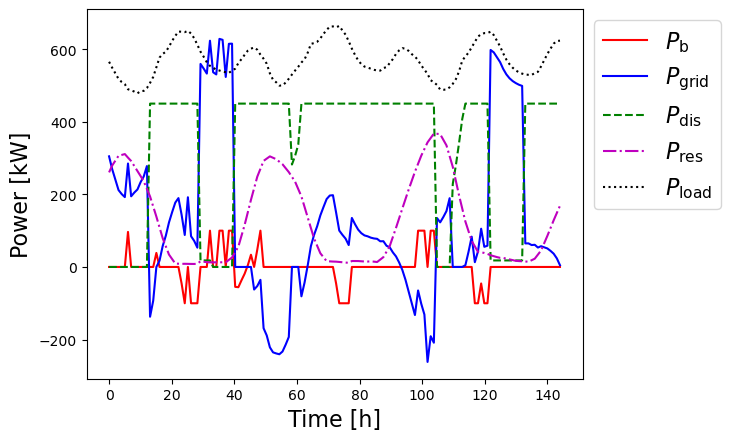

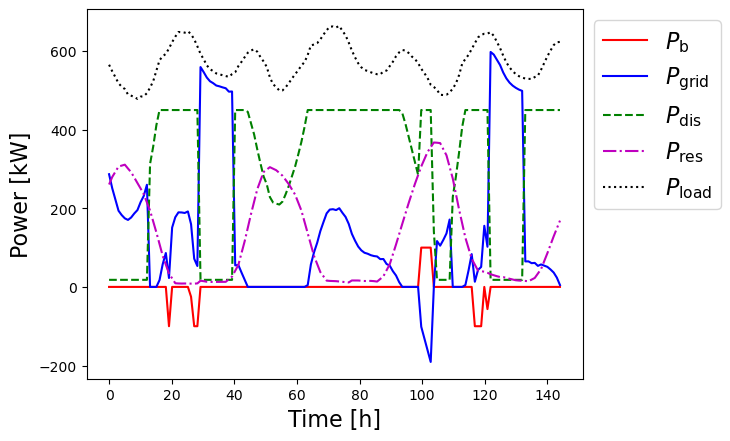

In [182]:
array_pb = np.array(list_pb)
array_pgrid = np.array(list_pgrid)
array_pdis = np.array(list_pdis)
array_pres = np.array(list_pres)
array_pload = np.array(list_pload)

array_pb_RL = np.array(list_pb_RL)
array_pgrid_RL = np.array(list_pgrid_RL)
array_pdis_RL = np.array(list_pdis_RL)

fontsize=16
time_hour = np.linspace(0, array_pb.shape[0], array_pb.shape[0])

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(time_hour, array_pb, '-r', label='$P_{\\mathrm{b}}$')
ax.plot(time_hour, array_pgrid, '-b', label='$P_{\\mathrm{grid}}$')
ax.plot(time_hour, array_pdis, '--g', label='$P_{\\mathrm{dis}}$')
ax.plot(time_hour, array_pres, '-.m', label='$P_{\\mathrm{res}}$')
ax.plot(time_hour, array_pload, ':k', label='$P_{\\mathrm{load}}$')
plt.xlabel('Time [h]', fontsize=fontsize)
plt.ylabel('Power [kW]', fontsize=fontsize)
ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=fontsize)
# plt.tight_layout()
fig.savefig('plots/closed_loop_optimal.pdf', bbox_inches='tight')
fig.show()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(time_hour, array_pb_RL, '-r', label='$P_{\\mathrm{b}}$')
ax.plot(time_hour, array_pgrid_RL, '-b', label='$P_{\\mathrm{grid}}$')
ax.plot(time_hour, array_pdis_RL, '--g', label='$P_{\\mathrm{dis}}$')
ax.plot(time_hour, array_pres, '-.m', label='$P_{\\mathrm{res}}$')
ax.plot(time_hour, array_pload, ':k', label='$P_{\\mathrm{load}}$')
plt.xlabel('Time [h]', fontsize=fontsize)
plt.ylabel('Power [kW]', fontsize=fontsize)
ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=fontsize)
# plt.tight_layout()
fig.savefig('plots/closed_loop_RL.pdf', bbox_inches='tight')
fig.show()

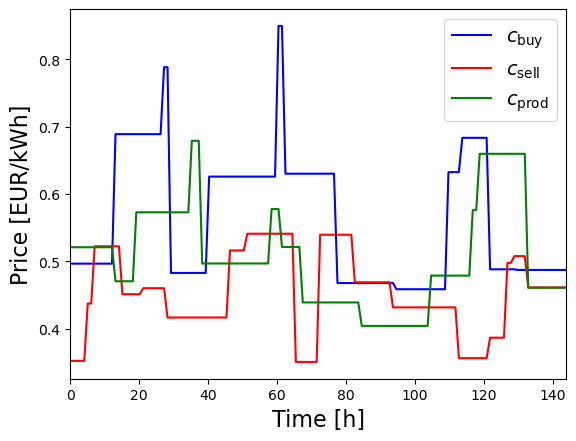

In [193]:
idx = Env.idx_cntr-144
array_cbuy = cbuy[idx:idx+N*3]
array_csell = csell[idx:idx+N*3]
array_cprod = cprod[idx:idx+N*3]

t = np.linspace(0, array_cbuy.shape[0], array_cbuy.shape[0])
# ticks = np.arange(0,26, 2)

fontsize=16
plt.plot(t, array_cbuy, 'b', label='$c_{\\mathrm{buy}}$')
plt.plot(t, array_csell, 'r', label='$c_{\\mathrm{sell}}$')
plt.plot(t, array_cprod, 'g', label='$c_{\\mathrm{prod}}$')
plt.xlim((0,144))
# plt.xticks(ticks)
plt.xlabel('Time [h]', fontsize=fontsize)
plt.ylabel('Price [EUR/kWh]', fontsize=fontsize)
plt.legend(fontsize=14, loc='upper right')
plt.savefig('plots/prices_power_plot.pdf', bbox_inches='tight')

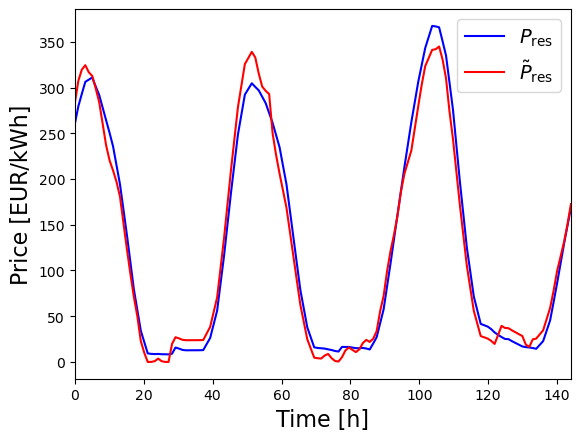

In [202]:
idx = Env.idx_cntr-144
array_power_res = power_res[idx:idx+N*3]
array_power_load = power_load[idx:idx+N*3]
array_power_res_noisy = power_res_noisy[idx:idx+N*3]
array_power_load_noisy = power_load_noisy[idx:idx+N*3]

t = np.linspace(0, array_cbuy.shape[0], array_cbuy.shape[0])

fontsize=16
plt.plot(t, array_power_res, 'b', label='$P_{\\mathrm{res}}$')
plt.plot(t, array_power_res_noisy, 'r', label='$\\tilde{P}_{\\mathrm{res}}$')
plt.xlim((0,144))
plt.xlabel('Time [h]', fontsize=fontsize)
plt.ylabel('Price [EUR/kWh]', fontsize=fontsize)
plt.legend(fontsize=14, loc='upper right')
plt.savefig('plots/res_power_mismatch.pdf', bbox_inches='tight')
plt.show()

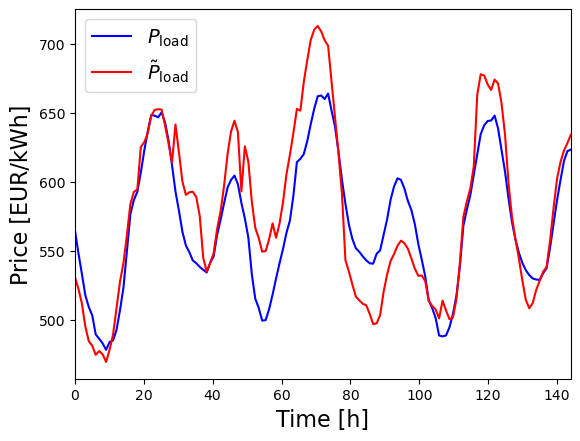

In [201]:
plt.plot(t, array_power_load, 'b', label='$P_{\\mathrm{load}}$')
plt.plot(t, array_power_load_noisy, 'r', label='$\\tilde{P}_{\\mathrm{load}}$')
plt.xlim((0,144))
plt.xlabel('Time [h]', fontsize=fontsize)
plt.ylabel('Price [EUR/kWh]', fontsize=fontsize)
plt.legend(fontsize=14, loc='best')
plt.savefig('plots/load_power_mismatch.pdf', bbox_inches='tight')
plt.show()

### Get trajectories of open-loop operation

In [91]:
Env.set_randState(power_res, power_load, cbuy, csell, cprod)

x0_tmp = np.repeat(Env.state, N)
state_SL = np.dstack((x0_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp, Env.power_res_tmp, Env.power_load_tmp)).squeeze()
state_SL = state_norm(state_SL, state_min_SL, state_max_SL).astype(np.float32)
state_SL = torch.tensor(state_SL, dtype=torch.float32).unsqueeze(0)
output_net = network_SL(state_SL, h0_SL, c0_SL)
action_idx_SL = torch.max(output_net, dim=2)[1].squeeze().numpy()
delta_SL = build_delta_vector(action_idx_SL, N, action_dict_SL)
mpc.build_opt_matrices(Env.state.reshape(-1,),delta_SL.reshape(-1,), Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
mdl_SL = mpc.solve_gurobi_lp()
sol_SL = np.array(mdl_SL.x).reshape(-1,)

state = preprocess_state(state_opt, Env.state, N, input_size, state_min, state_max, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp, Env.power_load_tmp, Env.power_res_tmp).astype(np.float32)
action = get_greedy_action(network,state,h0,c0)
delta = build_delta_vector(action, N, action_dict)
mpc.build_opt_matrices(Env.state.reshape(-1,),delta.reshape(-1,), Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
mdl_RL = mpc.solve_gurobi_lp()
sol_RL = np.array(mdl_RL.x).reshape(-1,)  

mpc.build_opt_matrices_hybrid(Env.power_res_tmp, Env.power_load_tmp, Env.cbuy_tmp, Env.csell_tmp, Env.cprod_tmp)
mdl_hybrid = mpc.solve_hybrid_gurobi(Env.state)
sol_hybrid_u = np.array(mdl_hybrid.x).reshape(-1,)[49:289]
sol_hybrid_z = np.array(mdl_hybrid.x).reshape(-1,)[289:385]

In [92]:
opt_gap = (mdl_RL.ObjVal-mdl_hybrid.ObjVal)/(mdl_hybrid.ObjVal)*100
print(opt_gap)

0.3540884634774536


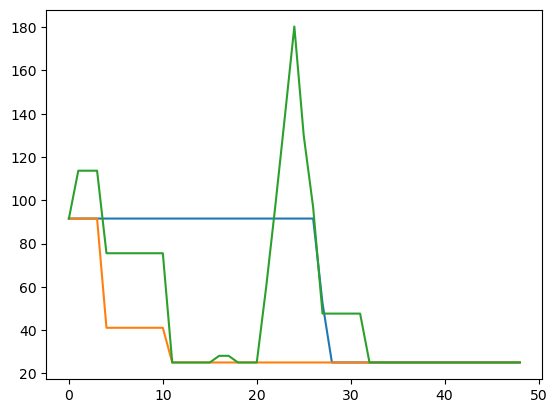

In [93]:
traj_x_RL = mpc.Gamma_x@Env.state.reshape(-1,) + mpc.Gamma_u_a@sol_RL
traj_x_SL = mpc.Gamma_x@Env.state.reshape(-1,) + mpc.Gamma_u_a@sol_SL
traj_x_hybrid = mpc.Gamma_x@Env.state.reshape(-1,) + mpc.Gamma_u@sol_hybrid_u + mpc.Gamma_z@sol_hybrid_z
plt.plot(traj_x_SL)
plt.plot(traj_x_RL, label='asd')
plt.plot(traj_x_hybrid)
plt.show()

C:\Users\caiof\AppData\Local\Temp\ipykernel_35724\2501005645.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


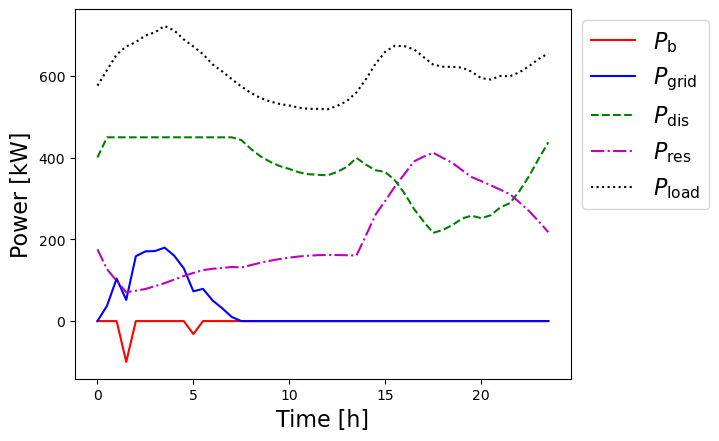

In [94]:
fontsize=16
time_hour = np.arange(48)/2

P_b = sol_RL[0::7]
P_grid = sol_RL[1::7]
P_dis = sol_RL[2::7] + sol_RL[3::7] + sol_RL[4::7]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(time_hour, P_b, '-r', label='$P_{\\mathrm{b}}$')
ax.plot(time_hour, P_grid, '-b', label='$P_{\\mathrm{grid}}$')
ax.plot(time_hour, P_dis, '--g', label='$P_{\\mathrm{dis}}$')
ax.plot(time_hour, Env.power_res_tmp, '-.m', label='$P_{\\mathrm{res}}$')
ax.plot(time_hour, Env.power_load_tmp, ':k', label='$P_{\\mathrm{load}}$')
plt.xlabel('Time [h]', fontsize=fontsize)
plt.ylabel('Power [kW]', fontsize=fontsize)
ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=fontsize)
# plt.tight_layout()
fig.savefig('plots/power_RL.pdf', bbox_inches='tight')
fig.show()

C:\Users\caiof\AppData\Local\Temp\ipykernel_35724\3399400881.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


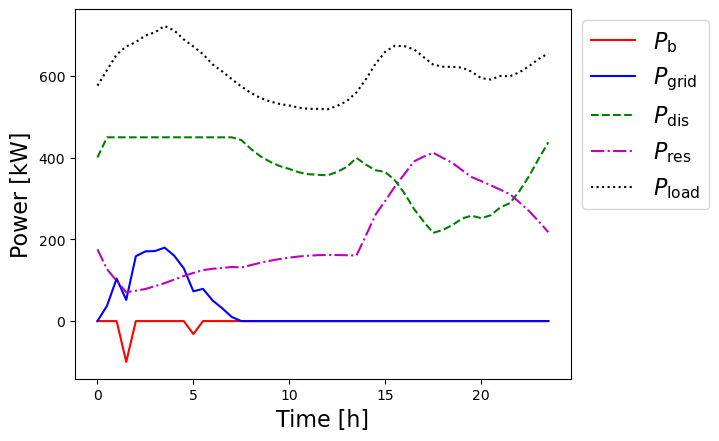

In [95]:
Pb = sol_hybrid_u[0::5]
Pgrid = sol_hybrid_u[1::5]
Pdis = sol_hybrid_u[2::5] + sol_hybrid_u[3::5] + sol_hybrid_u[4::5]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(time_hour, P_b, '-r', label='$P_{\\mathrm{b}}$')
ax.plot(time_hour, P_grid, '-b', label='$P_{\\mathrm{grid}}$')
ax.plot(time_hour, P_dis, '--g', label='$P_{\\mathrm{dis}}$')
ax.plot(time_hour, Env.power_res_tmp, '-.m', label='$P_{\\mathrm{res}}$')
ax.plot(time_hour, Env.power_load_tmp, ':k', label='$P_{\\mathrm{load}}$')
plt.xlabel('Time [h]', fontsize=fontsize)
plt.ylabel('Power [kW]', fontsize=fontsize)
ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=fontsize)
# plt.tight_layout()
fig.savefig('plots/power_milp.pdf', bbox_inches='tight')
fig.show()

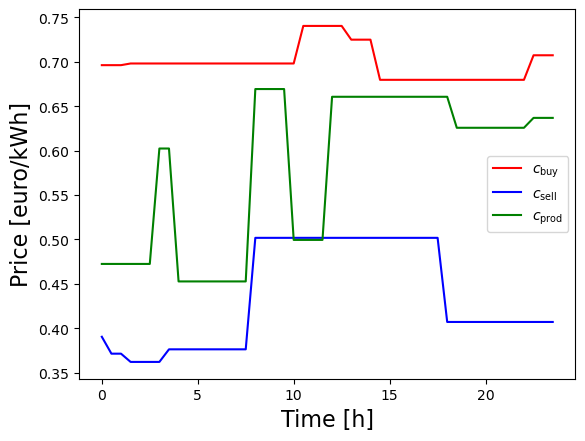

In [105]:
plt.figure()
# plt.plot(xb_vec[:-1]/300, 'y', label='$x_b$')
# plt.plot(delta_b, 'k', label='$\\delta_b$')
plt.plot(time_hour, Env.cbuy_tmp, 'r', label='$c_{\\mathrm{buy}}$')
plt.plot(time_hour, Env.csell_tmp, 'b', label='$c_{\\mathrm{sell}}$')
plt.plot(time_hour, Env.cprod_tmp, 'g', label='$c_{\\mathrm{prod}}$')
plt.xlabel('Time [h]', fontsize=fontsize)
plt.ylabel('Price [euro/kWh]', fontsize=fontsize)
plt.savefig('plots/prices_power_plot.pdf', bbox_inches='tight')
plt.legend()
plt.show()